# Modelowanie dla danych obrazowych

## Wstęp

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import skimage

from keras import layers
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
K.set_image_data_format('channels_last')
from tensorflow.keras.utils import to_categorical

from PIL import Image
import cv2

from copy import deepcopy
import os
import joblib

Baza danych zawiera 21165 zdjęć. Każde z nich przypisane jest do dokładnie jednej z kategorii:
* Normal
* COVID
* Lung Opacity
* Viral Pneumonia

## Załadowanie i preprocessing danych

In [2]:
categories_names = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']

In [3]:
fnames = [
    os.listdir(f'F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/{category}/images/')
    for category in categories_names
]
X_src, y = [], []
for i in range(len(fnames)):
    X_src += [f'F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/{categories_names[i]}/images/' + fname
             for fname in fnames[i]]
    y += [i] * len(fnames[i])
X_src = np.array(X_src)
y = np.array(y)

In [4]:
X_src

array(['F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-1.png',
       'F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10.png',
       'F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-100.png',
       ...,
       'F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-997.png',
       'F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-998.png',
       'F:/wb/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-999.png'],
      dtype='<U111')

In [5]:
y

array([0, 0, 0, ..., 3, 3, 3])

### Preprocessing
*(na podstawie pracy domowej 4.)*

In [6]:
class ImageResizer(TransformerMixin):
    def __init__(self, output_size):
        self.output_size = output_size
    def fit(self, X):
        return self
    def transform(self, X):
        X_new = deepcopy(X)
        for i in range(len(X)):
            if X[i].ndim == 3:
                X[i] = X[i][:, :, 0]
            X_new[i] = (skimage.transform.resize(X[i], self.output_size) * 255).astype('uint8')
        return X_new
    
class HistEqualizer(TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self
    def transform(self, X):
        X_new = deepcopy(X)
        for i in range(len(X)):
            if X[i].ndim == 3:
                X[i] = X[i][:, :, 0]
            X_new[i] = cv2.equalizeHist(X[i])
        return X_new

class TextRemover(TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
    def fit(self, X):
        return self
    def transform(self, X):
        X_new = deepcopy(X)
        for i in range(len(X)):
            if X[i].ndim == 3:
                X[i] = X[i][:, :, 0]
            mask = cv2.threshold(X[i], int(255*self.threshold), 255, cv2.THRESH_BINARY)[1]
            X_new[i] = cv2.inpaint(X[i], mask, 5, cv2.INPAINT_NS)
        return X_new

In [58]:
image_pipeline = make_pipeline(
    TextRemover(0.95),
    ImageResizer((128, 128)),
    HistEqualizer()
)

In [59]:
X = np.array( 
    image_pipeline.transform([
        np.asarray(Image.open(image_src)) for image_src in X_src
    ])
)
joblib.dump(X, 'X2.pkl')

['X2.pkl']

In [9]:
X = joblib.load('X2.pkl')

In [66]:
X = np.stack([X]*3, axis=-1) # zmiana z 1 kanału na 3 kanały

In [71]:
X.shape

(21165, 128, 128, 3)

### Podział danych na zbiór uczący, walidacyjny i testowy

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=765)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, stratify=y_train, random_state=876)

In [73]:
y_train, y_val, y_test = (to_categorical(y) for y in (y_train, y_val, y_test) ) #One-Hot Encoding na potrzeby trenowania

In [74]:
len(X_train), len(X_val), len(X_test)

(11904, 3969, 5292)

## Model (wersja 1. - cztery klasy)

Używamy zmodyfikowanej sieci AlexNet.

Na podstawie: https://github.com/keshav1245/Image-Classification-using-AlexNet-CNN-Model/blob/master/AlexNet_Classification.md

In [191]:
def AlexNet(input_shape, n_classes=4):
    
    X_input = Input(input_shape)
    
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    
    X = Flatten()(X)
    
    X = Dense(128, activation = 'relu', name = "fc0")(X)
    
    X = Dense(32, activation = 'relu', name = 'fc1')(X) 
    
    X = Dense(n_classes,activation='softmax',name = 'fc2')(X)
    
    model = Model(inputs = X_input, outputs = X, name='AlexNet')

    
    return model

In [76]:
alex = AlexNet(X_train.shape[1:])

In [77]:
alex.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv0 (Conv2D)              (None, 30, 30, 96)        34944     
                                                                 
 bn0 (BatchNormalization)    (None, 30, 30, 96)        384       
                                                                 
 activation_74 (Activation)  (None, 30, 30, 96)        0         
                                                                 
 max0 (MaxPooling2D)         (None, 14, 14, 96)        0         
                                                                 
 conv1 (Conv2D)              (None, 14, 14, 256)       614656    
                                                                 
 bn1 (BatchNormalization)    (None, 14, 14, 256)       1024

In [78]:
alex.compile(optimizer = 'adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

## Trenowanie modelu

In [79]:
history = alex.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
372/372 [==============================] - 285s 764ms/step - loss: 0.7238 - accuracy: 0.7210 - val_loss: 2.6558 - val_accuracy: 0.2089
Epoch 2/10
372/372 [==============================] - 292s 785ms/step - loss: 0.5378 - accuracy: 0.7944 - val_loss: 1.2094 - val_accuracy: 0.5571
Epoch 3/10
372/372 [==============================] - 286s 769ms/step - loss: 0.4603 - accuracy: 0.8263 - val_loss: 4.3186 - val_accuracy: 0.2275
Epoch 4/10
372/372 [==============================] - 292s 784ms/step - loss: 0.4135 - accuracy: 0.8425 - val_loss: 4.8957 - val_accuracy: 0.2074
Epoch 5/10
372/372 [==============================] - 315s 846ms/step - loss: 0.3598 - accuracy: 0.8657 - val_loss: 3.0643 - val_accuracy: 0.2444
Epoch 6/10
372/372 [==============================] - 324s 872ms/step - loss: 0.3188 - accuracy: 0.8826 - val_loss: 3.9058 - val_accuracy: 0.2472
Epoch 7/10
372/372 [==============================] - 315s 846ms/step - loss: 0.2984 - accuracy: 0.8879 - val_loss: 2.5143 -

## Wyniki pierwszego modelu

In [108]:
y_true = np.argmax(y_test, axis = 1)
y_pred = np.argmax(alex.predict(X_test), axis = 1)

### Accuracy

In [115]:
accuracy_score(y_true, y_pred)

0.31027966742252455

### Precision/recall

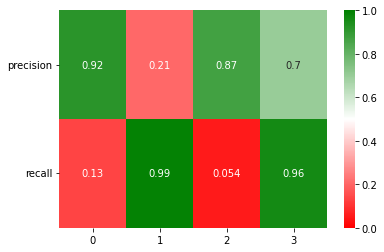

In [207]:
sns.heatmap(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).iloc[:-2, :-3], annot=True, cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256), vmin = 0, vmax = 1 )
plt.yticks(rotation=0)
plt.show()

### Confusion matrix

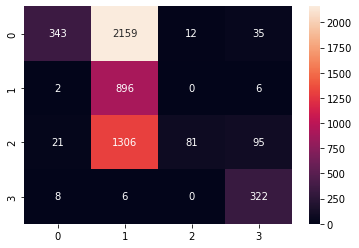

In [208]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
plt.show()

### Wnioski

Widzimy wyraźnie, że przyczyną tak niskiej dokładności na zbiorze walidacyjnym i testowym jest nagminne klasyfikowanie do kategorii `1` (COVID) obrazów, które w rzeczywistości należą do kategorii `0` (Normal) lub `2` (Lung opacity).

## Model (wersja 2. - trzy klasy)

Przeprowadźmy zatem drugie modelowanie, dla trzech klas (bez problematycznej klasy COVID).

In [193]:
X2 = X[y != 1]
y2 = y[y != 1]
y2[y2 == 3] = 1 # zamiana kategorii 3 na usuniętą 1

In [194]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size = 0.25, stratify=y2, random_state=765)
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train_2, y_train_2, test_size = 0.25, stratify=y_train_2, random_state=876)

In [195]:
y_train_2, y_val_2, y_test_2 = (to_categorical(y) for y in (y_train_2, y_val_2, y_test_2) )

In [196]:
len(X_train_2), len(X_val_2), len(X_test_2)

(9870, 3291, 4388)

In [197]:
model2 = AlexNet(X_train_2.shape[1:], n_classes=3)

In [198]:
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [199]:
history2 = model2.fit(X_train_2, y_train_2, validation_data=(X_val_2, y_val_2), epochs=10)

Epoch 1/10
309/309 [==============================] - 364s 1s/step - loss: 0.4447 - accuracy: 0.8326 - val_loss: 0.5151 - val_accuracy: 0.8034
Epoch 2/10
309/309 [==============================] - 236s 763ms/step - loss: 0.3136 - accuracy: 0.8807 - val_loss: 0.5007 - val_accuracy: 0.7934
Epoch 3/10
309/309 [==============================] - 232s 750ms/step - loss: 0.2700 - accuracy: 0.8991 - val_loss: 0.9990 - val_accuracy: 0.6670
Epoch 4/10
309/309 [==============================] - 235s 761ms/step - loss: 0.2405 - accuracy: 0.9074 - val_loss: 0.4338 - val_accuracy: 0.8250
Epoch 5/10
309/309 [==============================] - 239s 774ms/step - loss: 0.2378 - accuracy: 0.9091 - val_loss: 0.4826 - val_accuracy: 0.7998
Epoch 6/10
309/309 [==============================] - 235s 759ms/step - loss: 0.2139 - accuracy: 0.9178 - val_loss: 1.7667 - val_accuracy: 0.6120
Epoch 7/10
309/309 [==============================] - 234s 756ms/step - loss: 0.2121 - accuracy: 0.9208 - val_loss: 0.6532 - va

## Wyniki drugiego modelu

In [201]:
y_true_2 = np.argmax(y_test_2, axis = 1)
y_pred_2 = np.argmax(model2.predict(X_test_2), axis = 1)

### Accuracy

In [202]:
accuracy_score(y_true_2, y_pred_2)

0.8963081130355515

### Precision/recall

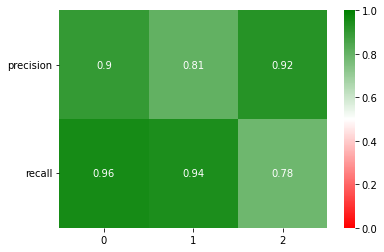

In [206]:
sns.heatmap(pd.DataFrame(classification_report(y_true_2, y_pred_2, output_dict=True)).iloc[:-2, :-3], annot=True, cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256), vmin = 0, vmax = 1 )
plt.yticks(rotation=0)
plt.show()

### Confusion matrix

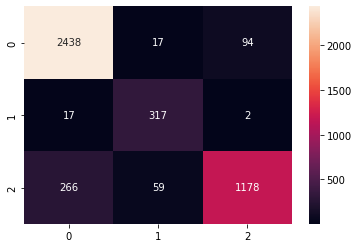

In [209]:
sns.heatmap(confusion_matrix(y_true_2, y_pred_2), annot=True, fmt='d')
plt.show()

### Wnioski

Wyniki drugiego modelu są satysfakcjonujące, uzyskaliśmy dokładność na zbiorze testowym równą ok. $90$% oraz wskaźniki pełności i precyzji w przedziale $78-96$%. Sieć, której budowa została oparta na architekturze sieci `AlexNet`, okazała się więc bardzo przydatna do rozróżniania osób:
* zdrowych;
* chorych na wirusowe zapalenie płuc;
* chorych na zmętnienie płuc.